# Load data

In [1]:
import sqlite3
import networkx as nx
import cbor2
import multiprocessing as mp
import logging


MAX_TIME_RUNS = 11 * 60 * 60
# RUNS_COUNT = 10
RUNS_COUNT = 5


logger = logging.getLogger()

# TODO: add proj4 (cannot open) "vusec@ripperoni/27022020fuzzertestsuitesubsetcostbenefit0proj47_data-vol/_data/collab/out/run_info.sqlite"
# TODO: add libarchive (no test cases) "ubuntu@fuzznew-2/26022020fuzzertestsuitesubsetseedsenfuzz1libarchive8_data-vol/_data/collab/out/run_info.sqlite"
# TODO: add sqlite (no test cases) ubuntu@fuzznew-2/26022020fuzzertestsuitesubsetseedsenfuzz1sqlite8_data-vol/_data/collab/out/run_info.sqlite
# fuzzer_test_suite_targets = ['guetzli', 'json', 'libpng', 'libxml2', 'woff2',
#                              'proj4', 'libarchive', 'sqlite']
fuzzer_test_suite_targets = ['guetzli', 'json', 'libarchive', 'libpng', 'libxml2',
                             'openssl-1.0.2d', 'openssl-1.1.0c', 'openthread', 'sqlite', 'woff2']

# fuzzer_test_suite_prefixes = {'enfuzz': 'ubuntu@fuzznew-2/26022020fuzzertestsuitesubsetseedsenfuzz1{}{}_data-vol',
#                               'broadcast': 'ubuntu@fuzznew-1/28022020fuzzertestsuitesubsetbroadcast0{}{}_data-vol',
#                               'benefit': 'ubuntu@fuzznew-2/26022020fuzzertestsuitesubsetseedsbenefit0{}{}_data-vol',
#                               'cost-benefit': 'vusec@ripperoni/27022020fuzzertestsuitesubsetcostbenefit0{}{}_data-vol'}
# fuzzer_test_suite_prefixes = {'enfuzz': '{}/enfuzz{}',
#                               'broadcast': '{}/broadcast{}',
#                               'benefit': '{}/benefit{}',
#                               'cost-benefit': '{}/cost-benefit{}'}
fuzzer_test_suite_prefixes = {'enfuzz': '{}/enfuzz{}',
                              'cf-div-benefit': '{}/cf-div-benefit{}',
                              'cf-div-cost-benefit': '{}/cf-div-cost-benefit{}'}

def load_data_global_coverage_run(db_str):
    db_query = ('SELECT tc.discovery_time, an_s.analysis_dump '
                'FROM test_cases tc '
                'JOIN analysis_states an_s ON tc.hash = an_s.test_case_hash '
                'JOIN analysis_types an_t ON an_s.analysis_id = an_t.id '
                'WHERE an_t.description = "global_coverage" '
                'ORDER BY tc.discovery_time;')

    try:
        with sqlite3.connect(db_str) as db_conn:
            db_cursor = db_conn.execute(db_query)
            rows = db_cursor.fetchall()
    except sqlite3.OperationalError as e:
        logger.warning(f'failed to interact with db {db_str}:\n{e}')
        return {}
    
    if len(rows) == 0:
        logger.warning(f'{db_str} has 0 rows')
        return {}
    print(f'{db_str} has {len(rows)} rows')

    # group by discovery time
    rows_grouped = {}
    for row in rows:
        discovery_time = row[0]
        diff_cov_dicts = cbor2.loads(row[1])
        if discovery_time in rows_grouped:
            rows_grouped[discovery_time].append(diff_cov_dicts)
        else:
            rows_grouped[discovery_time] = [diff_cov_dicts]

    # cumulatively build global coverage graph and
    # store number of edges into a dict with keys as discovery times
    g_cov = nx.DiGraph()
    time_to_covgraph = {}
    for discovery_time in sorted(rows_grouped.keys()):
        diffs = rows_grouped[discovery_time]
        g_cov.add_edges_from([(edge['source'], edge['target'])
                              for diff in diffs for edge in diff])
        time_to_covgraph[discovery_time] = g_cov.number_of_edges()
    print(f'{db_str} last discovery_time is {max(time_to_covgraph.keys())}')
    return time_to_covgraph

def load_all_global_coverage():
    # dict of target name to dict of scheduler to array of runs as returned from function above
    target_to_coverage = {}
    for target in fuzzer_test_suite_targets:
        target_to_coverage[target] = {}
        for sched_name, fmt_base in fuzzer_test_suite_prefixes.items():
            fmt_db = f'export-data-organized/{fmt_base}/_data/collab/out/run_info.sqlite'
            with mp.Pool() as pool:
                target_to_coverage[target][sched_name] = \
                    pool.starmap(load_data_global_coverage_run, [(fmt_db.format(target, run_i), )
                                                                 for run_i in range(1, RUNS_COUNT + 1)])
    return target_to_coverage

target_to_coverage = load_all_global_coverage()

export-data-organized/guetzli/enfuzz1/_data/collab/out/run_info.sqlite has 580 rows
export-data-organized/guetzli/enfuzz3/_data/collab/out/run_info.sqlite has 574 rows
export-data-organized/guetzli/enfuzz2/_data/collab/out/run_info.sqlite has 827 rows
export-data-organized/guetzli/enfuzz4/_data/collab/out/run_info.sqlite has 725 rows
export-data-organized/guetzli/enfuzz5/_data/collab/out/run_info.sqlite has 775 rows
export-data-organized/guetzli/enfuzz1/_data/collab/out/run_info.sqlite last discovery_time is 35928
export-data-organized/guetzli/enfuzz3/_data/collab/out/run_info.sqlite last discovery_time is 35900
export-data-organized/guetzli/enfuzz4/_data/collab/out/run_info.sqlite last discovery_time is 35931
export-data-organized/guetzli/enfuzz5/_data/collab/out/run_info.sqlite last discovery_time is 35659
export-data-organized/guetzli/enfuzz2/_data/collab/out/run_info.sqlite last discovery_time is 34952
export-data-organized/guetzli/cf-div-benefit2/_data/collab/out/run_info.sqlite h

export-data-organized/openthread/enfuzz5/_data/collab/out/run_info.sqlite has 0 rows


export-data-organized/openthread/enfuzz4/_data/collab/out/run_info.sqlite has 141 rows
export-data-organized/openthread/enfuzz1/_data/collab/out/run_info.sqlite last discovery_time is 27354
export-data-organized/openthread/enfuzz2/_data/collab/out/run_info.sqlite last discovery_time is 33662
export-data-organized/openthread/enfuzz3/_data/collab/out/run_info.sqlite last discovery_time is 35267
export-data-organized/openthread/enfuzz4/_data/collab/out/run_info.sqlite last discovery_time is 29083
export-data-organized/openthread/cf-div-benefit2/_data/collab/out/run_info.sqlite has 511 rows
export-data-organized/openthread/cf-div-benefit4/_data/collab/out/run_info.sqlite has 556 rows
export-data-organized/openthread/cf-div-benefit5/_data/collab/out/run_info.sqlite has 684 rows
export-data-organized/openthread/cf-div-benefit3/_data/collab/out/run_info.sqlite has 626 rows
export-data-organized/openthread/cf-div-benefit2/_data/collab/out/run_info.sqlite last discovery_time is 35626
export-dat

export-data-organized/sqlite/cf-div-cost-benefit2/_data/collab/out/run_info.sqlite has 0 rows
export-data-organized/sqlite/cf-div-cost-benefit4/_data/collab/out/run_info.sqlite has 0 rows


export-data-organized/sqlite/cf-div-cost-benefit3/_data/collab/out/run_info.sqlite has 175 rows
export-data-organized/sqlite/cf-div-cost-benefit1/_data/collab/out/run_info.sqlite has 282 rows
export-data-organized/sqlite/cf-div-cost-benefit5/_data/collab/out/run_info.sqlite has 509 rows
export-data-organized/sqlite/cf-div-cost-benefit1/_data/collab/out/run_info.sqlite last discovery_time is 3567
export-data-organized/sqlite/cf-div-cost-benefit3/_data/collab/out/run_info.sqlite last discovery_time is 10479
export-data-organized/sqlite/cf-div-cost-benefit5/_data/collab/out/run_info.sqlite last discovery_time is 34691
export-data-organized/woff2/enfuzz1/_data/collab/out/run_info.sqlite has 1616 rows
export-data-organized/woff2/enfuzz3/_data/collab/out/run_info.sqlite has 1186 rows
export-data-organized/woff2/enfuzz5/_data/collab/out/run_info.sqlite has 1081 rows
export-data-organized/woff2/enfuzz4/_data/collab/out/run_info.sqlite has 1234 rows
export-data-organized/woff2/enfuzz2/_data/col

In [2]:
import pandas as pd
import numpy as np
from scipy import stats


def build_dfs():
    dfs = {}
    for target, sched_dict in target_to_coverage.items():
        df_target_dict = {}
        for sched, runs in sched_dict.items():
            for run in runs:
                if len(run) == 0:
                    final_cov, csum = np.nan, np.nan
                else:
                    run_vals = list(run.values())
                    run_s = pd.Series(data=run_vals, index=map(lambda t: pd.Timedelta(t, unit='sec'), run.keys()))
                    new_index = pd.timedelta_range(start='0 sec', end=f'{MAX_TIME_RUNS} sec', freq='1S')
                    run_s = run_s.reindex(new_index, method='ffill', fill_value=0)
                    assert run_vals[-1] == run_s.max(), f'{run_vals[-1]} == {run_s.max()}'
                    final_cov = run_vals[-1]
                    csum = run_s.cumsum()[-1]
                
                if (sched + '_final') in df_target_dict:
                    df_target_dict[sched + '_final'].append(final_cov)
                    df_target_dict[sched + '_cumsum'].append(csum)
                    df_target_dict[sched + '_series'].append(run_s)
                else:
                    df_target_dict[sched + '_final'] = [final_cov]
                    df_target_dict[sched + '_cumsum'] = [csum]
                    df_target_dict[sched + '_series'] = [run_s]
        columns = [s + '_final' for s in sched_dict.keys()] + \
                  [s + '_cumsum' for s in sched_dict.keys()] + \
                  [s + '_series' for s in sched_dict.keys()]
        dfs[target] = pd.DataFrame.from_dict(df_target_dict)[columns]
    return dfs

def build_aucs(dfs):
    aucs = {}
    for target, df in dfs.items():
        if target not in aucs:
            aucs[target] = {}
        for col in fuzzer_test_suite_prefixes.keys():
            series = df.loc[:, f'{col}_series']
            series_mat = np.ndarray((RUNS_COUNT, MAX_TIME_RUNS + 1))
            for i, (_, s) in enumerate(series.items()):
                series_mat[i, :] = s.to_numpy()
            median_runs = np.median(series_mat, axis=0)
            # print(target, col)
            # print(median_runs)
            auc = median_runs.sum()
            # print(auc)
            aucs[target][col] = auc
    return pd.DataFrame.from_records(aucs).T

def check_aucs_significance(dfs):
    # schedulers = ['broadcast', 'benefit', 'cost-benefit']
    schedulers = ['cf-div-benefit', 'cf-div-cost-benefit']
    aucs = {}
    improvements = np.ndarray((len(dfs), len(schedulers)))
    for target_i, (target, df) in enumerate(dfs.items()):
        if target not in aucs:
            aucs[target] = {}
        for col in fuzzer_test_suite_prefixes.keys():
            series = df.loc[:, f'{col}_series']
            series_mat = np.ndarray((RUNS_COUNT, MAX_TIME_RUNS + 1))
            for i, (_, s) in enumerate(series.items()):
                series_mat[i, :] = s.to_numpy()
            auc_runs = series_mat.sum(axis=1)
            aucs[target][col] = auc_runs
        for sched_i, col in enumerate(schedulers):
            r = stats.mannwhitneyu(aucs[target][col], aucs[target]['enfuzz'])
            print(target, col, r)
            our_m = np.median(aucs[target][col])
            enfuzz_m = np.median(aucs[target]['enfuzz'])
            ratio = our_m / enfuzz_m
            improvements[target_i, sched_i] = ratio
            print(ratio)
            stat_sign_str = ''
            if our_m > enfuzz_m:
                stat_sign_str = 'better '
            else:
                stat_sign_str = 'not better '
            if r.pvalue < 0.05:
                stat_sign_str += 'with stat significance'
            else:
                stat_sign_str += 'without stat significance'
            print(stat_sign_str, '\n')
    print(stats.gmean(improvements, axis=0))

target_dfs = build_dfs()
aucs = build_aucs(target_dfs)
check_aucs_significance(target_dfs)
aucs

guetzli cf-div-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
1.11062363378319
better with stat significance 

guetzli cf-div-cost-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
1.1062251377892391
better with stat significance 

json cf-div-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
1.1307792872923967
better with stat significance 

json cf-div-cost-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
1.1306768349330656
better with stat significance 

libarchive cf-div-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
2.083505904091287
better with stat significance 

libarchive cf-div-cost-benefit MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
2.059699254695482
better with stat significance 

libpng cf-div-benefit MannwhitneyuResult(statistic=5.0, pvalue=0.07183604090348011)
1.0441747981097298
better without stat significance 

libpng cf-div-cost-benefit Ma

,enfuzz,cf-div-benefit,cf-div-cost-benefit
guetzli,178574011.0,198504567.0,197339509.0
json,54353913.0,61504237.0,61524899.0
libarchive,126267758.0,264179036.0,260812763.0
libpng,53166890.0,55492316.0,60031454.0
libxml2,170485021.0,290809137.0,295808723.0
openssl-1.0.2d,56001052.0,56999615.0,56996059.0
openssl-1.1.0c,49816950.0,50640511.0,50684965.0
openthread,62999680.0,80660530.0,64695822.0
sqlite,57637795.0,68175216.0,68098431.0
woff2,113002927.0,120577389.0,118273507.0


guetzli
enfuzz 202590000 178481463.0 0.8809983859025619
cf-div-benefit 202590000 198225731.0 0.9784576287082284
cf-div-cost-benefit 202590000 197440681.0 0.9745825608371588

json
enfuzz 61693200 54376493.0 0.8814017266084431
cf-div-benefit 61693200 61487812.0 0.9966708162325831
cf-div-cost-benefit 61693200 61482241.0 0.9965805145461737

libarchive
enfuzz 291571200 127661644.0 0.4378403765529654
cf-div-benefit 291571200 265983789.0 0.9122430095976557
cf-div-cost-benefit 291571200 262944593.0 0.9018194972617323

libpng
enfuzz 63079200 53123412.0 0.8421700338621922
cf-div-benefit 63079200 55470128.0 0.879372725082119
cf-div-cost-benefit 63079200 59961178.0 0.9505697282146889

libxml2
enfuzz 382690800 171554796.0 0.4482856551555459
cf-div-benefit 382690800 290666483.0 0.7595335006746962
cf-div-cost-benefit 382690800 295057505.0 0.7710075732157659

openssl-1.0.2d
enfuzz 57099600 55882919.0 0.9786919523078971
cf-div-benefit 57099600 57011420.0 0.9984556809504795
cf-div-cost-benefit 57099600 

<ipython-input-3-9cc6efa6dbbc>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


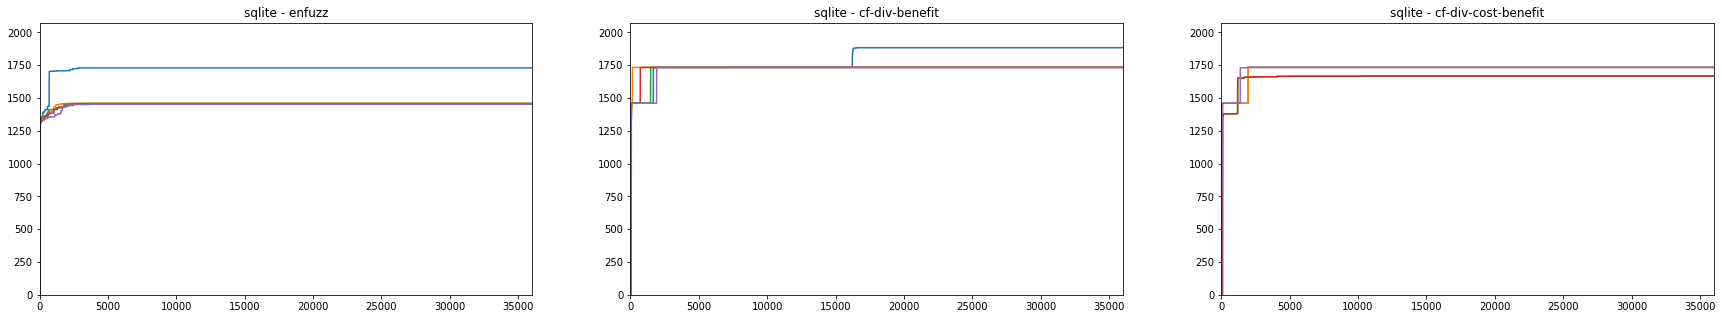

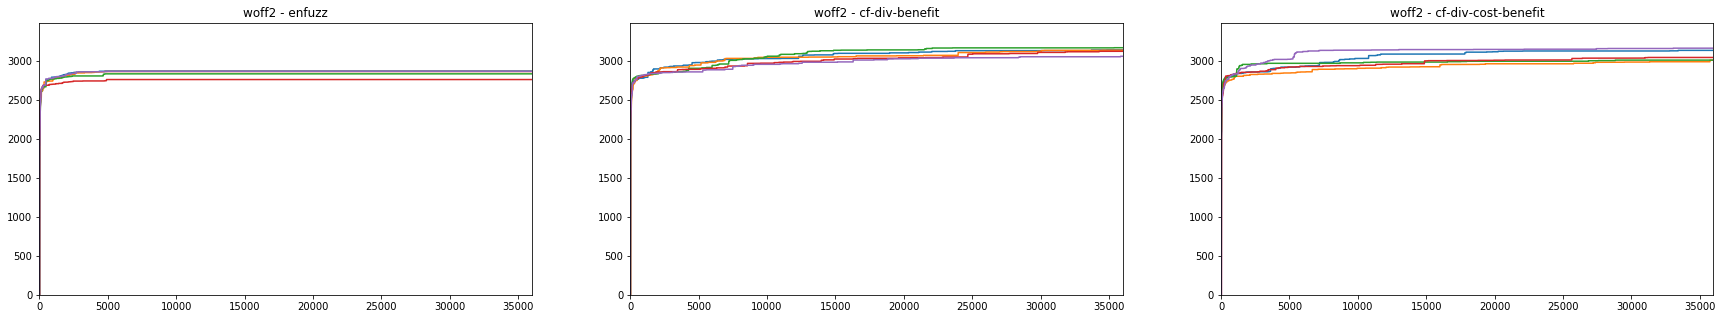

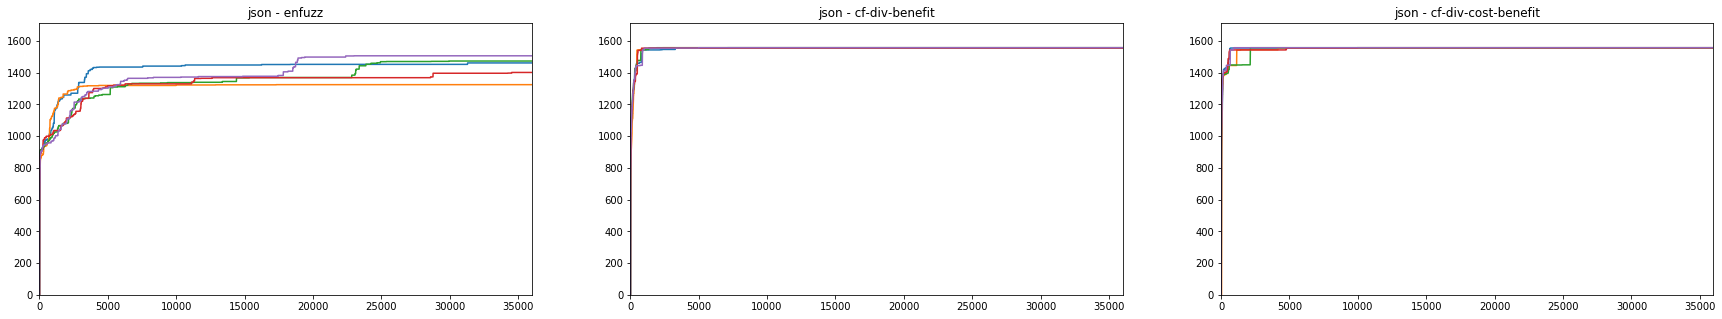

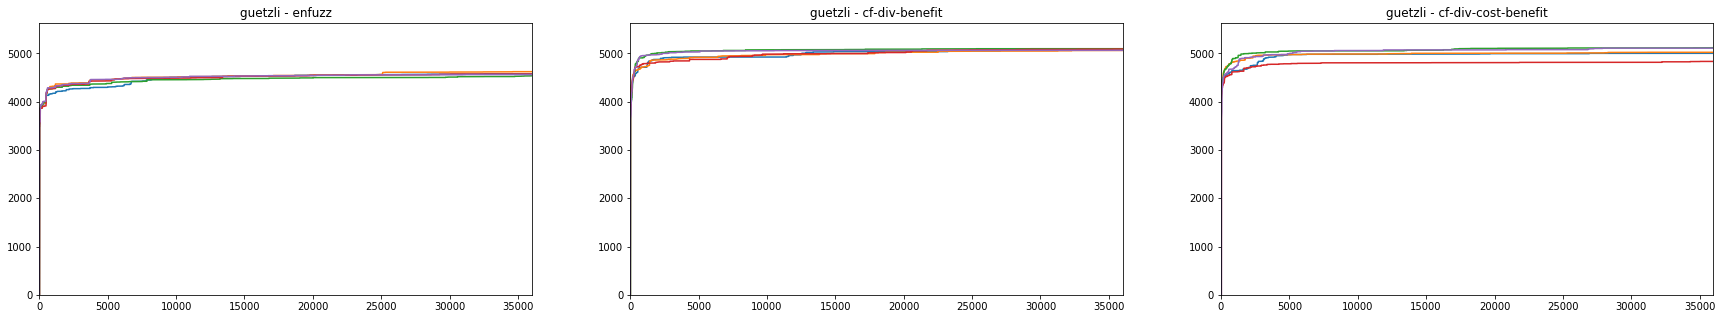

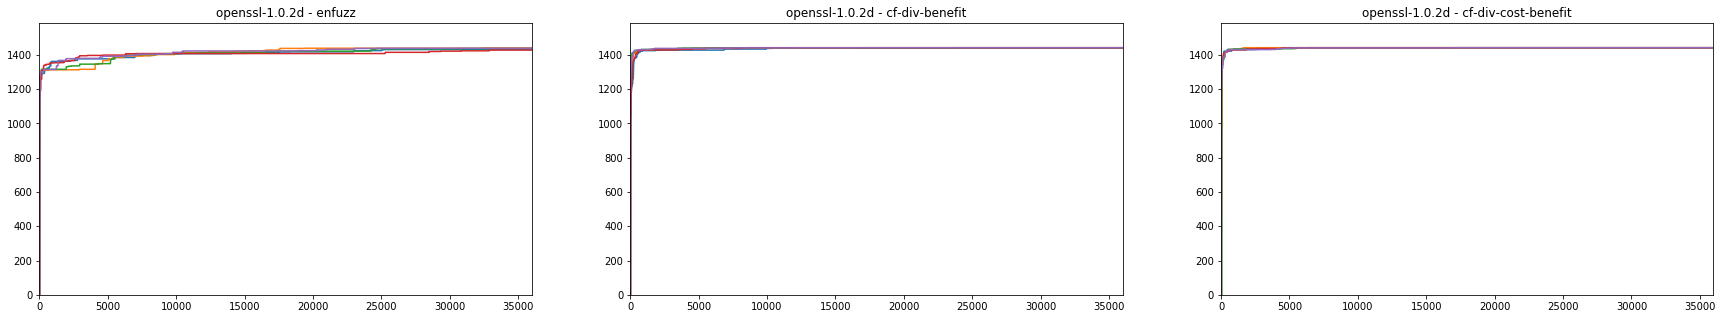

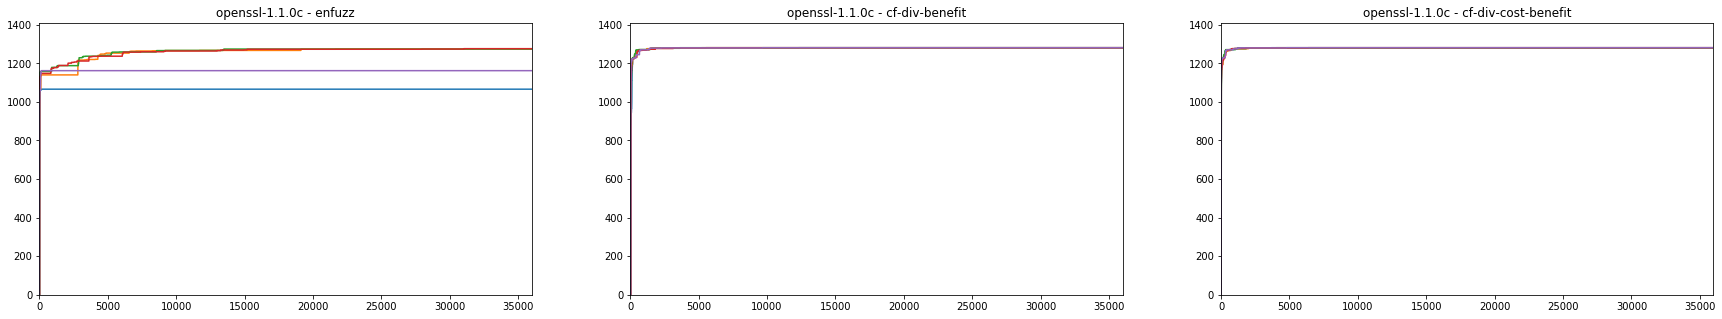

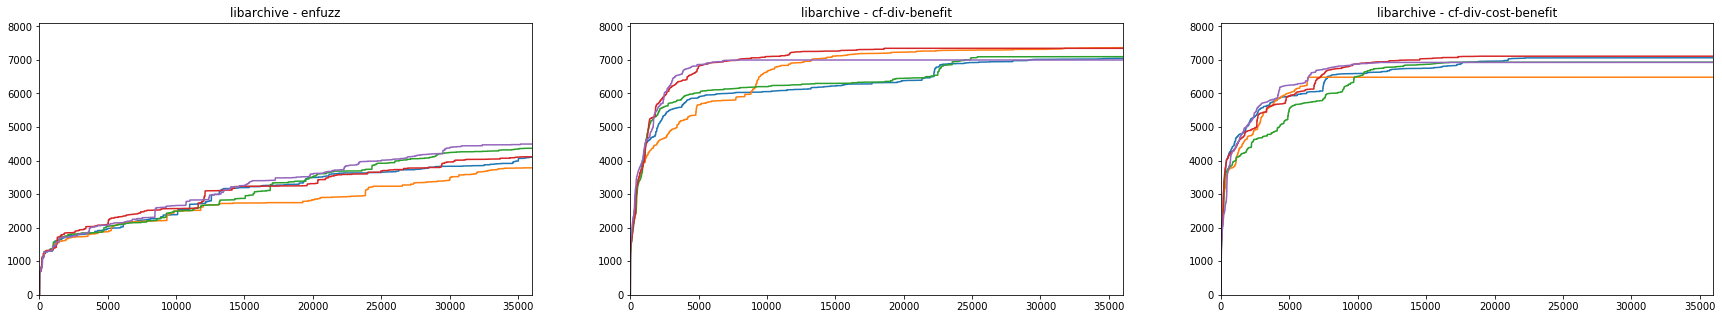

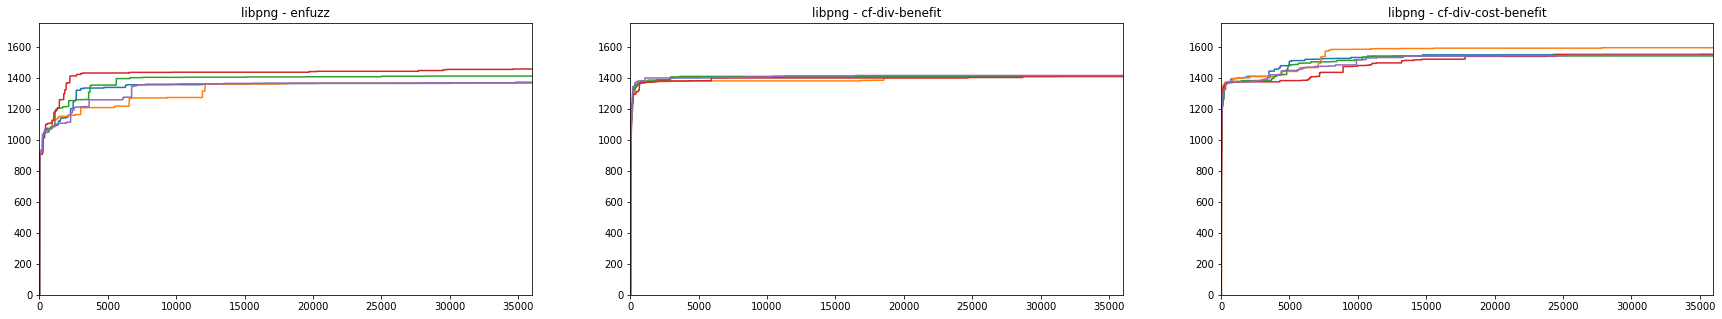

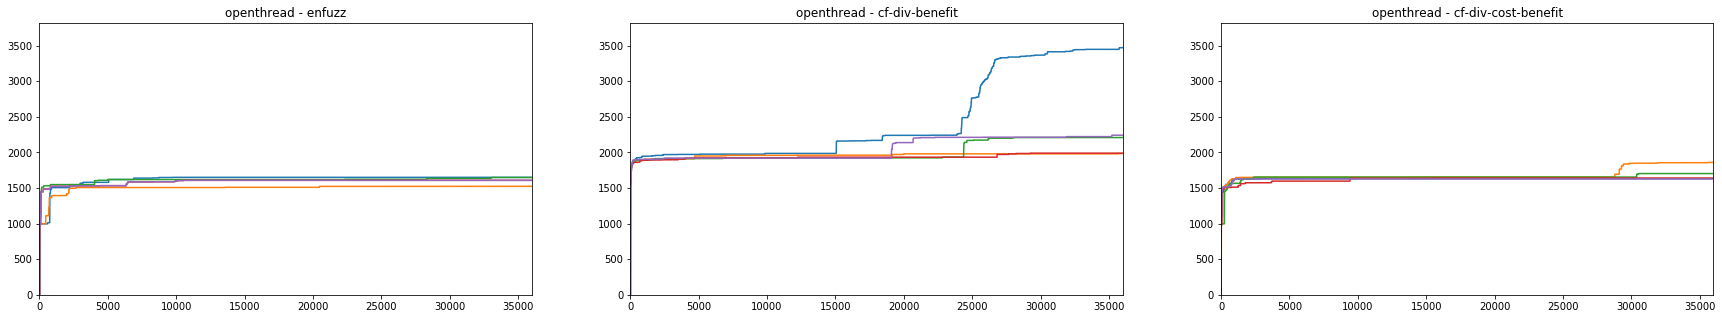

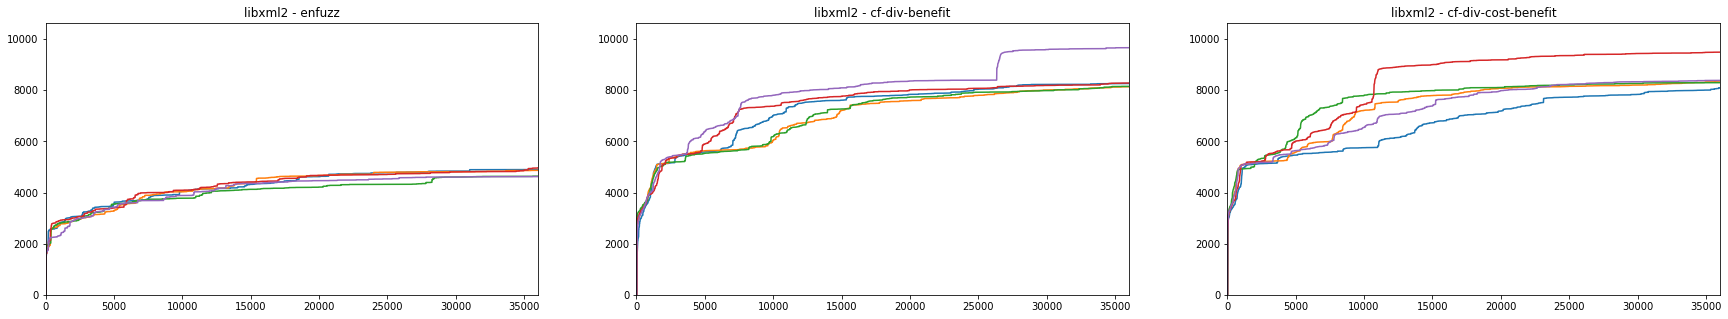

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_runs(target):
    runs = target_dfs[target]
    num_schedulers = len(list(fuzzer_test_suite_prefixes.keys()))
    fig, axs = plt.subplots(1, num_schedulers)
    fig.set_size_inches(30, 5)
    mx = runs[[c for c in runs.columns if '_final' in c]].max().max()
    ret_str = f'{target}\n'
    for sched, ax in zip(fuzzer_test_suite_prefixes.keys(), axs.flatten()):
        series = runs[sched + '_series']
        ax.set_title(f'{target} - {sched}')
        ax.set_xlim(0, MAX_TIME_RUNS - 60 * 60)
        ax.set_ylim(0, mx * 1.1)
        for serie in series.values:
            ax.plot([td.seconds for td in serie.index], serie.values)
        csum = runs[sched + '_cumsum'].median()
        mx_auc = mx * MAX_TIME_RUNS - 60 * 60
        ret_str += f'{sched} {mx_auc} {csum} {csum / mx_auc}\n'
    return fig, ret_str
        
with mp.Pool() as pool:
    results = pool.map(plot_runs, fuzzer_test_suite_targets)
    for fig, s in results:
        print(s)
        fig.show()

In [4]:
for target, df in target_dfs.items():
    print(target, '\n\n', df.describe(), '\n\n')

guetzli 

        enfuzz_final  cf-div-benefit_final  cf-div-cost-benefit_final  \
count      5.000000              5.000000                   5.000000   
mean    4572.000000           5079.800000                5015.200000   
std       31.208973             17.880157                 114.471394   
min     4534.000000           5059.000000                4832.000000   
25%     4560.000000           5062.000000                5000.000000   
50%     4572.000000           5088.000000                5021.000000   
75%     4574.000000           5095.000000                5107.000000   
max     4620.000000           5095.000000                5116.000000   

       enfuzz_cumsum  cf-div-benefit_cumsum  cf-div-cost-benefit_cumsum  
count   5.000000e+00           5.000000e+00                5.000000e+00  
mean    1.782425e+08           1.987989e+08                1.969021e+08  
std     1.053419e+06           1.273378e+06                4.306083e+06  
min     1.767218e+08           1.976025e+08 

In [5]:
def check_significance(col_suffix, alpha=5e-2):
    percs, percs_mx, ratios = {}, {}, {}
    for target, df_og in target_dfs.items():
        if target in ['proj4']:
            continue
        columns = [c for c in df_og.columns if col_suffix in c]
        mx = df_og[[c for c in df_og.columns if '_final' in c]].max().max()
        if col_suffix == '_cumsum':
            mx = mx * (MAX_TIME_RUNS)
        print(f'{target}:')
        for i in range(len(columns) - 1):
            for j in range(i + 1, len(columns)):
                c1 = columns[i]
                c2 = columns[j]
                df1, df2 = df_og.loc[:, c1].dropna(), df_og.loc[:, c2].dropna()
                r = stats.mannwhitneyu(df1, df2)
                m1 = df1.median()
                m2 = df2.median()
                perc_mx = ((m1 - m2) / (mx - min(m1, m2))) * 100
                # perc = ((m1 - m2) / max(m1, m2)) * 100
                perc = ((m1 - m2) / m1) * 100
                ratio = m2 / m1
                if f'{c1} vs {c2}' not in percs:
                    percs[f'{c1} vs {c2}'] = []
                    percs_mx[f'{c1} vs {c2}'] = []
                    ratios[f'{c1} vs {c2}'] = []
                percs_mx[f'{c1} vs {c2}'].append(perc_mx)
                percs[f'{c1} vs {c2}'].append(perc)
                ratios[f'{c1} vs {c2}'].append(ratio)
                print('\t{} {} vs. {} (+ first is better)'.format('g' if r.pvalue < alpha else 'b', c1, c2))
                print('\t\tsamples {} {}'.format(df1.size, df2.size))
                print('\t\tmedian {:.1f} {:.1f} {:.1f}'.format(m1, m2, mx))
                print('\t\tdiff {:.1f}'.format(m1 - m2))
                print('\t\tperc_mx {:f}%'.format(perc_mx))
                print('\t\tperc {:f}%'.format(perc))
                print('\t\tratio {:f}%'.format(ratio))
                print('\t\t{:.5f} (p-value {:.5f})'.format(r.statistic, r.pvalue))
    return percs, percs_mx, ratios

for k, v in check_significance('_final')[2].items():
    print('{:<16} {:.5f} {:.5f}'.format(k, stats.gmean(v), 1-stats.gmean(v)))

guetzli:
	g enfuzz_final vs. cf-div-benefit_final (+ first is better)
		samples 5 5
		median 4572.0 5088.0 5116.0
		diff -516.0
		perc_mx -94.852941%
		perc -11.286089%
		ratio 1.112861%
		0.00000 (p-value 0.00596)
	g enfuzz_final vs. cf-div-cost-benefit_final (+ first is better)
		samples 5 5
		median 4572.0 5021.0 5116.0
		diff -449.0
		perc_mx -82.536765%
		perc -9.820647%
		ratio 1.098206%
		0.00000 (p-value 0.00609)
	b cf-div-benefit_final vs. cf-div-cost-benefit_final (+ first is better)
		samples 5 5
		median 5088.0 5021.0 5116.0
		diff 67.0
		perc_mx 70.526316%
		perc 1.316824%
		ratio 0.986832%
		10.00000 (p-value 0.33759)
json:
	g enfuzz_final vs. cf-div-benefit_final (+ first is better)
		samples 5 5
		median 1462.0 1558.0 1558.0
		diff -96.0
		perc_mx -100.000000%
		perc -6.566347%
		ratio 1.065663%
		0.00000 (p-value 0.00485)
	g enfuzz_final vs. cf-div-cost-benefit_final (+ first is better)
		samples 5 5
		median 1462.0 1558.0 1558.0
		diff -96.0
		perc_mx -100.000000%
		p

<ipython-input-5-733f367c3329>:19: RuntimeWarning: invalid value encountered in double_scalars
  perc_mx = ((m1 - m2) / (mx - min(m1, m2))) * 100


In [6]:
# for k, v in check_significance('_cumsum')[2].items():
#    print('{:<16} {:.5f}'.format(k, np.mean(v), stats.gmean(v)))

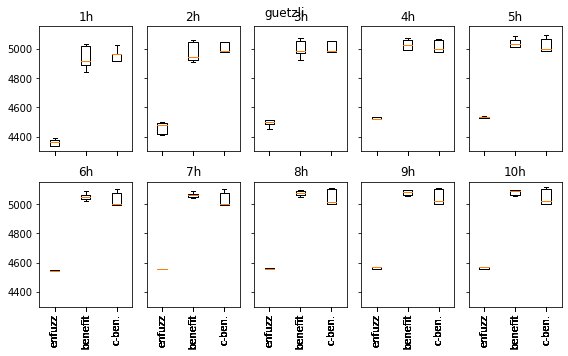

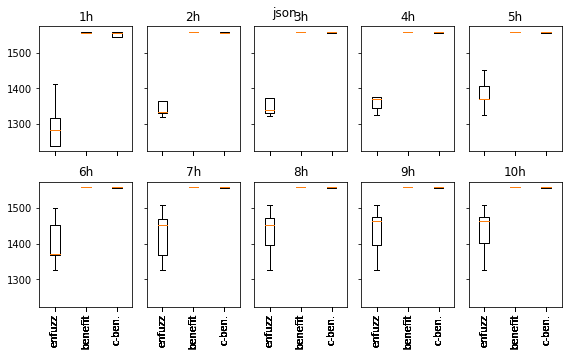

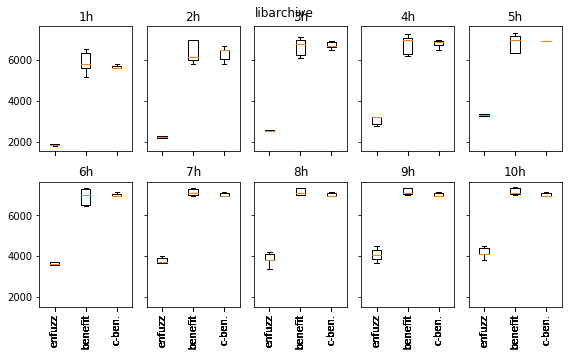

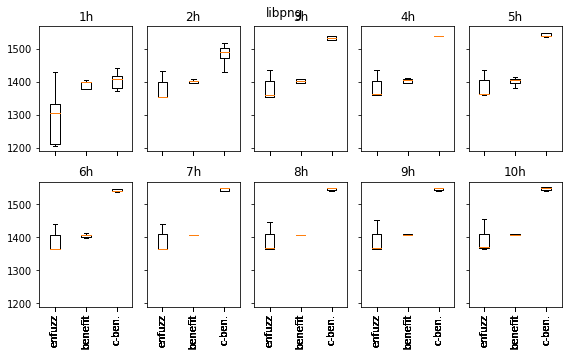

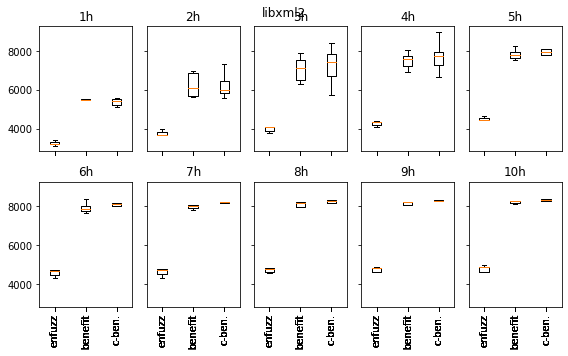

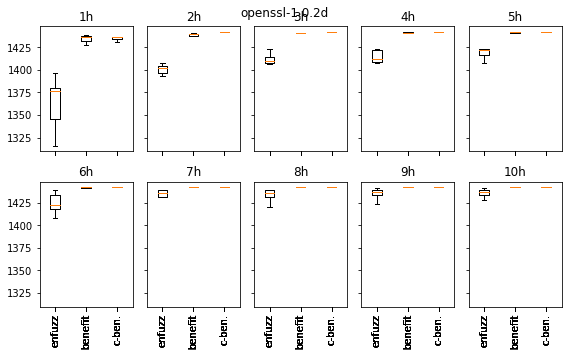

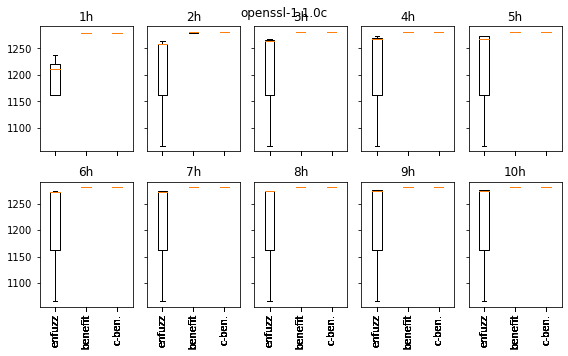

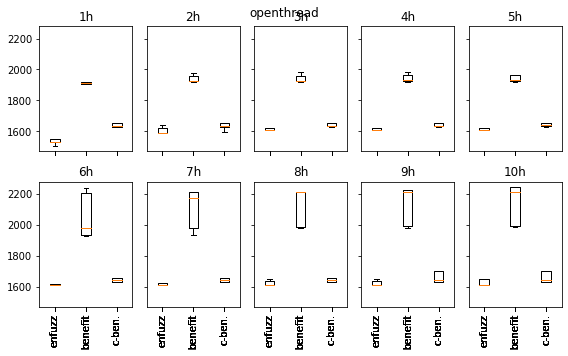

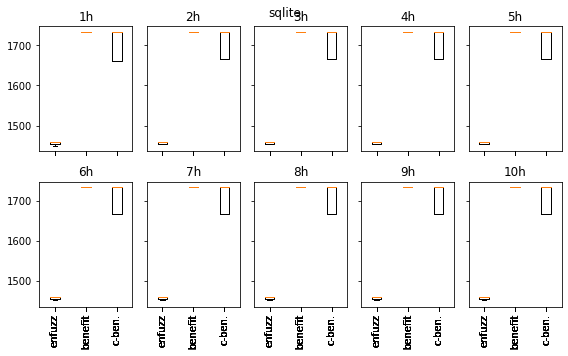

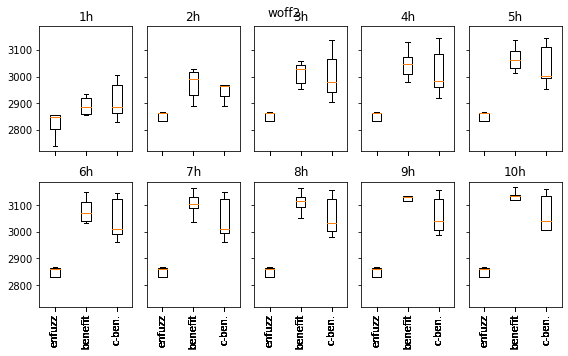

In [7]:
def make_boxplot_at_time_intervals():
    time_range = pd.timedelta_range('1H', f'{MAX_TIME_RUNS}S', freq='1H')
    # labels = ['enfuzz', 'broad.', 'benefit', 'c-ben.']
    labels = ['enfuzz', 'benefit', 'c-ben.']
    for target, target_df in target_dfs.items():
        fig, axs = plt.subplots(2, 5, sharex=True, sharey=True)
        fig.suptitle(target)
        fig.set_size_inches(8, 5)
        target_series = []
        for sched in fuzzer_test_suite_prefixes.keys():
            df_runs = {}
            for i, run_s in enumerate(target_df[sched + '_series']):
                df_runs[i] = run_s
            df_runs = pd.DataFrame.from_dict(df_runs)
            target_series.append(df_runs.loc[time_range, :])
        for i, (td, ax) in enumerate(zip(time_range, axs.flatten())):
            ax.set_title(f'{int(td.seconds / (60 * 60))}h')
            ax.get_xaxis().set_tick_params(labelrotation=90)
            ax.boxplot([s.loc[td, :] for s in target_series], showfliers=False, labels=labels)
        fig.tight_layout()
        fig.savefig(f'coverage-boxplot-{target}.png')

make_boxplot_at_time_intervals()

In [8]:
def get_improvements_coverage(target_dfs):
    time_range = pd.timedelta_range('1H', f'{MAX_TIME_RUNS}S', freq='1H')
    schedulers = ['broadcast', 'benefit', 'cost-benefit']
    # build dict for each comparison, value is array of ratios (our / enfuzz) to be indexed by time_range
    time_to_ratios = { 'broadcast vs enfuzz': [],
                       'benefit vs enfuzz': [],
                       'cost-benefit vs enfuzz': [],
                       'perfect vs enfuzz': [] }
    target_dfs = { k: v for k, v in target_dfs.items() if k not in ['proj4'] }
    
    max_obs_final_coverage_per_target = {}
    for target, target_df in target_dfs.items():
        df_runs = target_df[[sched + '_series' for sched in schedulers + ['enfuzz']]]
        max_obs_final_coverage_per_target[target] = df_runs.applymap(lambda run_serie: run_serie.max()).max().max()
    print(max_obs_final_coverage_per_target)
    
    for td in time_range:
        ratios = np.zeros((len(target_dfs), len(schedulers) + 1))
        for i_target, (target, target_df) in enumerate(target_dfs.items()):
            df_runs = target_df[[sched + '_series' for sched in schedulers + ['enfuzz']]]
            medians = df_runs.applymap(lambda run_serie: run_serie[td]).median()
            assert medians.size == len(schedulers) + 1, f'{medians.size}'
            # print(td, target, '\n', medians, '\n')
            for i_sched, sched in enumerate(schedulers):
                ratios[i_target, i_sched] = medians[sched + '_series'] / medians['enfuzz_series']
            ratios[i_target, len(schedulers)] = max_obs_final_coverage_per_target[target] / medians['enfuzz_series']
        # mean_ratios = stats.gmean(ratios, axis=0)
        mean_ratios = np.mean(ratios, axis=0)
        assert mean_ratios.shape == (len(schedulers) + 1, ), f'{mean_ratios.shape}'
        time_to_ratios['broadcast vs enfuzz'].append(mean_ratios[0])
        time_to_ratios['benefit vs enfuzz'].append(mean_ratios[1])
        time_to_ratios['cost-benefit vs enfuzz'].append(mean_ratios[2])
        time_to_ratios['perfect vs enfuzz'].append(mean_ratios[3])
    return pd.DataFrame.from_records(time_to_ratios, index=time_range)

# print(get_improvements_coverage(target_dfs).to_markdown())

In [9]:
def get_improvements_time_quantiles(target_dfs, gmean=True):
    time_range = pd.timedelta_range('1H', f'{MAX_TIME_RUNS}S', freq='1H')
    schedulers = ['broadcast', 'benefit', 'cost-benefit']
    schedulers_en = schedulers + ['enfuzz']
    series_columns = [sched + '_series' for sched in schedulers_en]
    
    target_dfs = { k: v for k, v in target_dfs.items() if k not in ['proj4'] }
    
    # flatten runs into ndarray
    target_dfs_np = np.ndarray((len(target_dfs), len(schedulers_en), RUNS_COUNT, MAX_TIME_RUNS + 1))
    for target_i, (target, target_df) in enumerate(target_dfs.items()):
        df_runs = target_df[series_columns]
        for sched_i, sched in enumerate(schedulers_en):
            for run_i in range(RUNS_COUNT):
                target_dfs_np[target_i, sched_i, run_i] = df_runs.loc[run_i, sched + '_series'].values
    
    # get quantiles for coverage, per target
    qs = [.05, .25, .5, .75]
    quantiles = np.quantile(target_dfs_np, qs, interpolation='midpoint', axis=(2, 3, 1)).transpose()
    assert quantiles.shape == (len(target_dfs), len(qs)), quantiles.shape
    quantiles_df = pd.DataFrame.from_records(quantiles, index=target_dfs.keys(), columns=qs)
    print(quantiles_df.to_markdown(), '\n')

    # ndarray containing times per target, aggregate over those with geomean later
    targets_q_time = np.ndarray((len(qs), len(schedulers_en), len(target_dfs)))
    for q_i, q in enumerate(qs):
        for target_i, (target, target_row) in enumerate(quantiles_df.iterrows()):
            # get coverage at quantile for this target
            q_cov = target_row[q]
            # get dataframe with runs for single target
            target_df = target_dfs[target]
            # for each run (cells are series) get latest index (time) for which we see coverage q_cov
            df_runs = target_df[series_columns].applymap(lambda rs: rs[rs <= q_cov].index[-1].seconds)
            # for each scheduler, get the median time across runs (df_runs[sched_series] contains the time to get to q_cov per run)
            print(f'{target} @ {q} cov: {quantiles_df.loc[target, q]}')
            print(df_runs.median())
            for sched in schedulers:
                print(sched, stats.mannwhitneyu(df_runs.loc[:, f'{sched}_series'], df_runs.enfuzz_series))
            print()
            targets_q_time[q_i, :, target_i] = df_runs.median()
    print(targets_q_time)
    
    ratios = np.ndarray((len(qs), len(schedulers), len(target_dfs)))
    for q_i, q in enumerate(qs):
        for sched_i, _ in enumerate(schedulers):
            for target_i, _ in enumerate(target_dfs):
                ratios[q_i, sched_i, target_i] = targets_q_time[q_i, sched_i, target_i] / targets_q_time[q_i, len(schedulers), target_i]
    
    # aggregate over targets with geomean
    # final_df = pd.DataFrame(stats.gmean(targets_q_time, axis=2), index=qs, columns=schedulers_en)
    # print(final_df.to_markdown(), '\n')

    # compare our scheduler vs enfuzz
    # final_dict = {}
    # for col in schedulers:
    #     final_dict[f'{col} vs enfuzz'] = final_df[col] / final_df['enfuzz']
    #     gmeans_np = final_df[[col, 'enfuzz']].values
    #     final_dict[f'{col} vs enfuzz %'] = ((gmeans_np[:, 0] - gmeans_np[:, 1]) / gmeans_np.max(axis=1)) * 100
    # return pd.DataFrame.from_dict(final_dict)
    
    if gmean:
        final_df = pd.DataFrame(stats.gmean(ratios, axis=2), index=qs, columns=[f'{s} vs enfuzz' for s in schedulers])
    else:
        final_df = pd.DataFrame(np.mean(ratios, axis=2), index=qs, columns=[f'{s} vs enfuzz' for s in schedulers])
    print(final_df.to_markdown(), '\n')

    # compare our scheduler vs enfuzz
    final_dict = {}
    return pd.DataFrame.from_dict(final_dict)

# print(get_improvements_time_quantiles(target_dfs).to_markdown())

In [10]:
def get_improvements_time(target_dfs, gmean=True):
    time_range = pd.timedelta_range('1H', f'{MAX_TIME_RUNS}S', freq='1H')
    schedulers = ['broadcast', 'benefit', 'cost-benefit']
    schedulers_en = schedulers + ['enfuzz']
    series_columns = [sched + '_series' for sched in schedulers_en]
    
    target_dfs = { k: v for k, v in target_dfs.items() if k not in ['proj4'] }
    
    # flatten runs into ndarray
    target_dfs_np = np.ndarray((len(target_dfs), len(schedulers_en), RUNS_COUNT, MAX_TIME_RUNS + 1))
    for target_i, (target, target_df) in enumerate(target_dfs.items()):
        df_runs = target_df[series_columns]
        for sched_i, sched in enumerate(schedulers_en):
            for run_i in range(RUNS_COUNT):
                target_dfs_np[target_i, sched_i, run_i] = df_runs.loc[run_i, sched + '_series'].values
    
    # get quantiles for coverage, per target
    # qs = [.05, .25, .5, .75]
    # quantiles = np.quantile(target_dfs_np, qs, interpolation='midpoint', axis=(2, 3, 1)).transpose()
    # assert quantiles.shape == (len(target_dfs), len(qs)), quantiles.shape
    # quantiles_df = pd.DataFrame.from_records(quantiles, index=target_dfs.keys(), columns=qs)
    
    # per target, get max seen coverage across runs across schedulers
    mx_targets = np.max(np.median(np.max(target_dfs_np, axis=3), axis=2), axis=1)
    assert mx_targets.shape[0] == len(fuzzer_test_suite_targets)
    print(mx_targets)
    
    qs = [.9, .95, .97, .99]
    quantiles = np.array(qs).reshape(-1, 1).dot(mx_targets.reshape(1, -1))
    quantiles_df = pd.DataFrame.from_records(quantiles.transpose() , index=target_dfs.keys(), columns=qs)
    
    print(quantiles_df.to_markdown(), '\n')
    
    # ndarray containing times per target, aggregate over those with geomean later
    targets_q_time = np.ndarray((len(qs), len(schedulers_en), len(target_dfs)))
    for q_i, q in enumerate(qs):
        stat_significant = { s: 0 for s in schedulers }
        stat_significant_cases_count = { s: 0 for s in schedulers }
        for target_i, (target, target_row) in enumerate(quantiles_df.iterrows()):
            # get coverage at quantile for this target
            q_cov = target_row[q]
            # get dataframe with runs for single target
            target_df = target_dfs[target]
            # for each run (cells are series) get latest index (time) for which we see coverage q_cov
            df_runs = target_df[series_columns].applymap(lambda rs: rs[rs <= q_cov].index[-1].seconds)
            # for each scheduler, get the median time across runs (df_runs[sched_series] contains the time to get to q_cov per run)
            # print(f'{target} @ {q} cov: {quantiles_df.loc[target, q]}')
            # print(df_runs.median())
            stat_significant_cases = 0
            total_cases = 0
            for sched in schedulers:
                try:
                    r = stats.mannwhitneyu(df_runs.loc[:, f'{sched}_series'], df_runs.enfuzz_series)
                    # print(sched, r)
                    stat_significant[sched] += 1 if r[1] < 0.05 else 0
                    stat_significant_cases_count[sched] += 1
                except ValueError as e:
                    print(e)
            # print()
            targets_q_time[q_i, :, target_i] = df_runs.median()
        for sched in schedulers:
            print(f'Stat. significant cases for {sched}: {stat_significant[sched]} / {stat_significant_cases_count[sched]}')
        print()
    # print(targets_q_time)
    
    ratios = np.ndarray((len(qs), len(schedulers), len(target_dfs)))
    for q_i, q in enumerate(qs):
        for sched_i, _ in enumerate(schedulers):
            for target_i, _ in enumerate(target_dfs):
                ratios[q_i, sched_i, target_i] = targets_q_time[q_i, sched_i, target_i] / targets_q_time[q_i, len(schedulers), target_i]
    print(ratios, '\n')
    
    # aggregate over targets with geomean
    # final_df = pd.DataFrame(stats.gmean(targets_q_time, axis=2), index=qs, columns=schedulers_en)
    # print(final_df.to_markdown(), '\n')

    # compare our scheduler vs enfuzz
    # final_dict = {}
    # for col in schedulers:
    #     final_dict[f'{col} vs enfuzz'] = final_df[col] / final_df['enfuzz']
    #     gmeans_np = final_df[[col, 'enfuzz']].values
    #     final_dict[f'{col} vs enfuzz %'] = ((gmeans_np[:, 0] - gmeans_np[:, 1]) / gmeans_np.max(axis=1)) * 100
    # return pd.DataFrame.from_dict(final_dict)
    
    if gmean:
        final_df = pd.DataFrame(stats.gmean(ratios, axis=2), index=qs, columns=[f'{s} vs enfuzz' for s in schedulers])
    else:
        final_df = pd.DataFrame(np.mean(ratios, axis=2), index=qs, columns=[f'{s} vs enfuzz' for s in schedulers])
    print(final_df.to_markdown(), '\n')

    # compare our scheduler vs enfuzz
    final_dict = {}
    return pd.DataFrame.from_dict(final_dict)

# print(get_improvements_time(target_dfs).to_markdown())